## Classificação de imagem utilizando SVM

### Importa as bibliotecas a serem utilizadas

In [2]:
%matplotlib inline

import pandas as pd
import time
import wandb
import os
from mod_util import *

In [3]:
# Globais
df_model_metrics = pd.DataFrame()

In [4]:
# Coleta de métrias de hardware
os.environ["WANDB_NOTEBOOK_NAME"] = "mnist.ipynb"
#os.environ["WANDB_API_KEY"] = "key"
wandb.init(project="svm")

wandb: Currently logged in as: adsantos (ml-ipt). Use `wandb login --relogin` to force relogin


### Carrega as bases pré-segmentadas de treinamento e testes

In [5]:
x_train, y_train, x_test, y_test = load_mnist_dataset()

### Exibe bitmap de exemplo da primeira imagem da base de treinamento

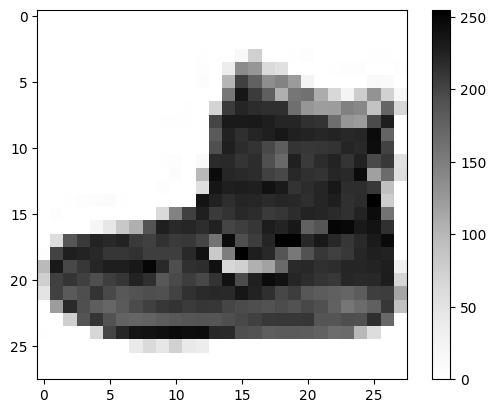

In [6]:
exibe_bitmap_primeira_imagem(x_train)

### Exibe dados das amostras de treinamento e testes

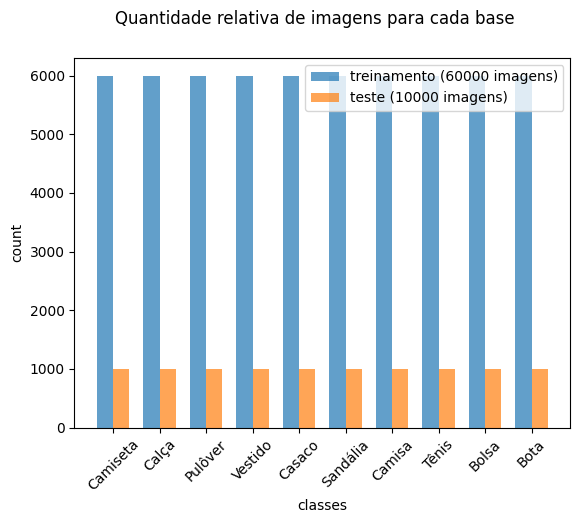

In [7]:
plota_barras_treinamento_e_teste(y_train, y_test)

As distribuições são iguais entre todas as características nesta base de dados

### Processamento

Utiliza o HOG (Histogram of Oriented Gradient) para reduzir as características das imagens. É verdade que a base de imagens já está reduzida. Ainda assim, vamos aplicar esse método padronizado para avaliar o seu impacto no resultado final.

#### Grade com amostra das imagens originais em escala de cinza

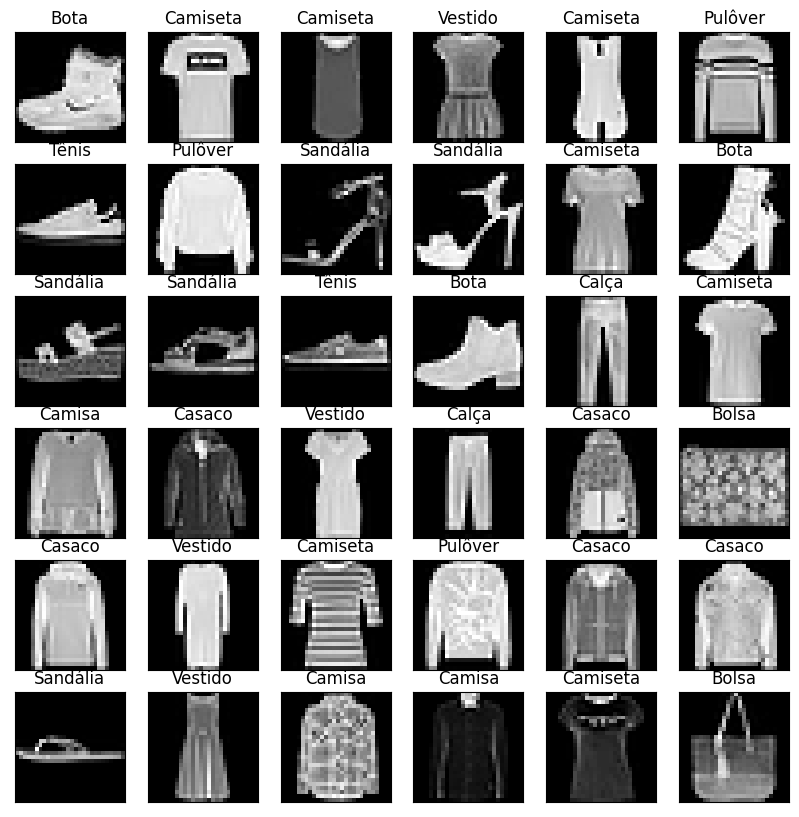

In [8]:
exibe_grade_imagens(AMOSTRAS_GRID, x_train, y_train)

#### Amostras HOG

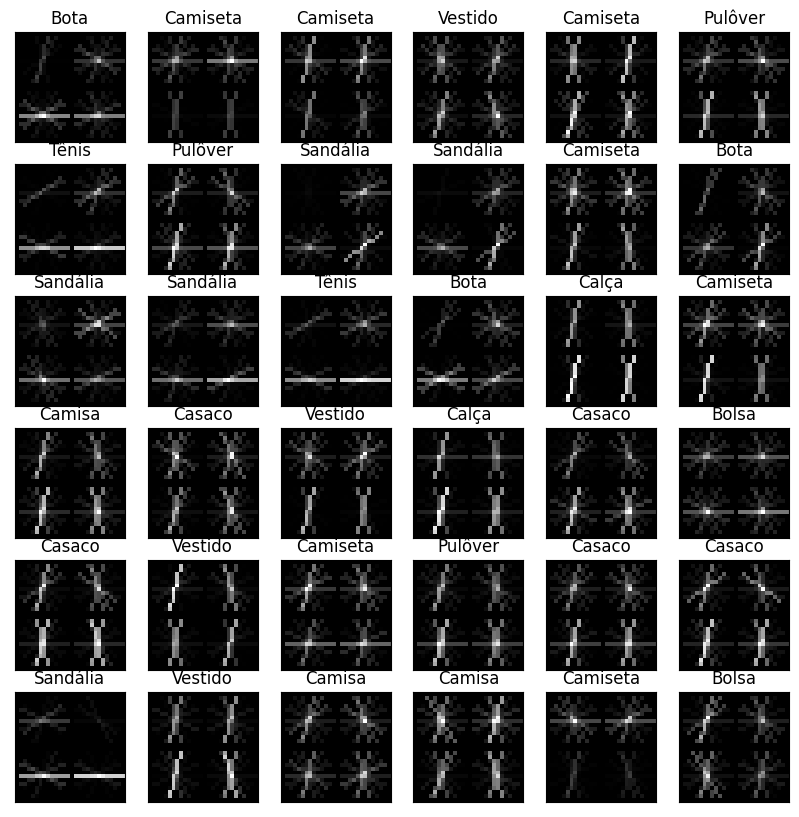

In [9]:
feat_hog, img_hog = gera_amostras_hog(AMOSTRAS_GRID, x_train)
exibe_grade_imagens(AMOSTRAS_GRID, img_hog, y_train, must_reshape=False)

É perceptível pelas características acima que a transformação HOG mantém poucos elementos da imagem. As imagens também ficam muito parecidas. A redução de pixels é significativa:

### Comparação de características (features) entre original e HOG

In [10]:
comparativo_imagem_hog(x_train[0], img_hog[0])

Pixels da imagem original:  784
Características HOG:  28


### Treinamento

Treina um modelo classificador gradiente descent utilizando SVM, utilizando as características reduzidas HOG

In [11]:
start = time.perf_counter()
model = treina_com_hog(x_train, y_train)
end = time.perf_counter()

train_duration_SVM_HOG = end - start

#### Base de Testes

Faz as transformações na base de testes e então aplica as predições e analisa o percentual de acertos

In [12]:
start = time.perf_counter()
predicoes_com_hog = model.predict(x_test)
end = time.perf_counter()
predict_duration_SVM_HOG = end - start

exibe_percentual_de_acerto(predicoes_com_hog, y_test)

Percentual de acerto:  71.03


#### Matriz de confusão

Monta matriz de confusão para analisar o resultado na base de testes

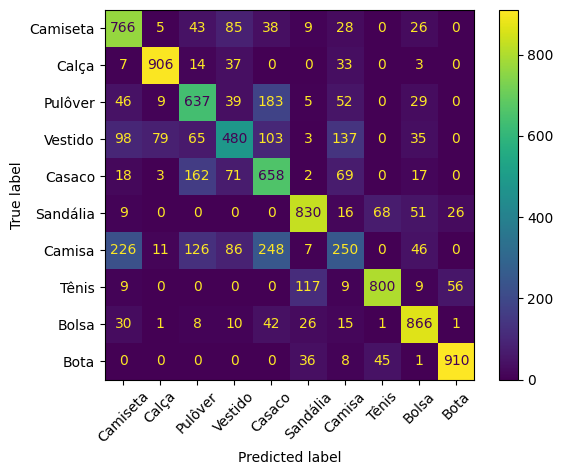

In [13]:
plot_confusion_matrix(y_test, predicoes_com_hog)

In [14]:
# Classification Report for DenseNet169 Model
cr = show_classification_report_svm(y_test, predicoes_com_hog, CLASS_NAMES, "SVM-HOG")

# Prepare report
df_model_metrics = df_model_metrics.append(add_model_metrics(cr, train_duration_SVM_HOG, predict_duration_SVM_HOG, "SVM-HOG", 3))

Relatório de classificação para modelo SVM-HOG: 
                precision    recall  f1-score   support

    Camiseta       0.63      0.77      0.69      1000
       Calça       0.89      0.91      0.90      1000
     Pulôver       0.60      0.64      0.62      1000
     Vestido       0.59      0.48      0.53      1000
      Casaco       0.52      0.66      0.58      1000
    Sandália       0.80      0.83      0.82      1000
      Camisa       0.41      0.25      0.31      1000
       Tênis       0.88      0.80      0.84      1000
       Bolsa       0.80      0.87      0.83      1000
        Bota       0.92      0.91      0.91      1000

    accuracy                           0.71     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.70      0.71      0.70     10000



### Otimização

O percentual de acerto de 71% é ruim. Pra buscar melhorar a performance aplicamos cross-validation utilizando grid-search pra buscar a melhor combinação de parâmetros

In [15]:
start = time.perf_counter()
modelo_otimizado = treina_com_hog_otimizado(x_train, y_train)
end = time.perf_counter()
# Fitting 3 folds for each of 14 candidates, totalling 42 fits
train_duration_SVM_HOG_OPT = (end - start) / 42

salva_modelo(modelo_otimizado, "modelo_otimizado")

Fitting 3 folds for each of 14 candidates, totalling 42 fits


d:\miniconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


12 fits failed out of a total of 42.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "d:\miniconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\miniconda3\envs\ml\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "d:\miniconda3\envs\ml\lib\site-packages\sklearn\pipeline.py", line 355, in _fit
    **fit_params_steps[name],
  File "d:\miniconda3\envs\ml\lib\site-packages\joblib\memory.py"

Lista o conjunto de parâmetros no pipeline que tiveram a melhor performance. Depois apresenta o melhor percentual de acerto

In [16]:
exibe_otimizacao(modelo_otimizado)

Melhores parâmetros:
{   'classify': SVC(kernel='linear'),
    'hogify__cells_per_block': (3, 3),
    'hogify__orientations': 8,
    'hogify__pixels_per_cell': (8, 8)}
Melhor pontuação (score): 0.8249666666666666


In [17]:
start = time.perf_counter()
predicoes_otimizado = modelo_otimizado.predict(x_test)
end = time.perf_counter()
predict_duration_SVM_HOG_OPT = end - start

exibe_percentual_de_acerto(predicoes_otimizado, y_test)

Percentual de acerto:  81.89


### Matriz de confusão

Matriz de confusão do cenário otimizado, antes refaz a matriz do cenário anterior para comparação

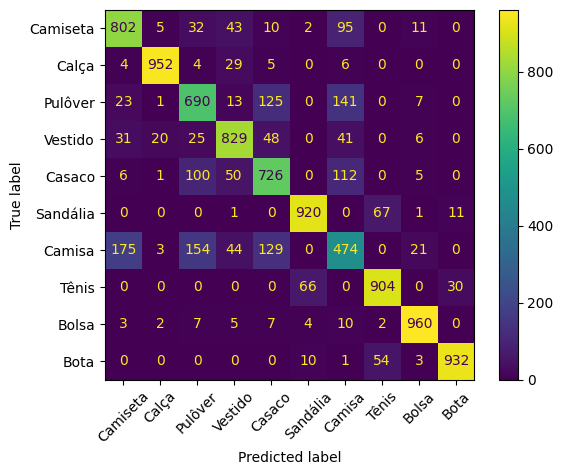

In [18]:
plot_confusion_matrix(y_test, predicoes_otimizado)

In [19]:
# Classification Report for DenseNet169 Model
cr = show_classification_report_svm(y_test, predicoes_otimizado, CLASS_NAMES, "SVM-HOG-OPT")

# Prepare report
df_model_metrics = df_model_metrics.append(add_model_metrics(cr, train_duration_SVM_HOG_OPT, predict_duration_SVM_HOG_OPT, "SVM-HOG-OPT", 4))

Relatório de classificação para modelo SVM-HOG-OPT: 
                precision    recall  f1-score   support

    Camiseta       0.77      0.80      0.78      1000
       Calça       0.97      0.95      0.96      1000
     Pulôver       0.68      0.69      0.69      1000
     Vestido       0.82      0.83      0.82      1000
      Casaco       0.69      0.73      0.71      1000
    Sandália       0.92      0.92      0.92      1000
      Camisa       0.54      0.47      0.50      1000
       Tênis       0.88      0.90      0.89      1000
       Bolsa       0.95      0.96      0.95      1000
        Bota       0.96      0.93      0.94      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



### Sem redução de parâmetros (HOG)

Agora fazemos o treinamento sem a redução HOG de parâmetros

In [20]:

start = time.perf_counter()
modelo_sem_hog = treina_sem_hog(x_train, y_train)
end = time.perf_counter()
train_duration_SVM = end - start

start = time.perf_counter()
predicoes_sem_hog = modelo_sem_hog.predict(x_test)
end = time.perf_counter()

predict_duration_SVM = end - start

exibe_percentual_de_acerto(predicoes_sem_hog, y_test)

Percentual de acerto:  71.03


#### Matriz de confusão

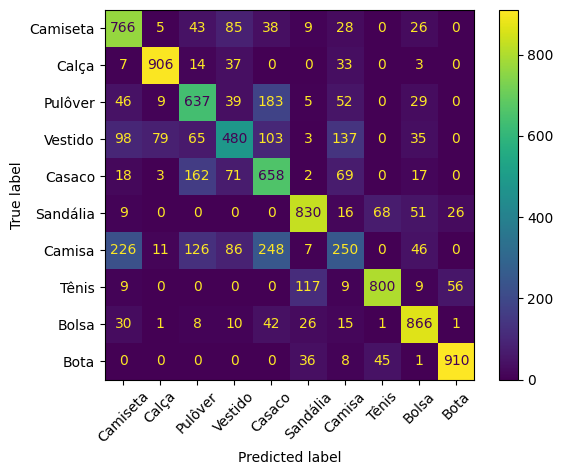

In [21]:
plot_confusion_matrix(y_test, predicoes_sem_hog)

In [22]:
# Classification Report for DenseNet169 Model
cr = show_classification_report_svm(y_test, predicoes_sem_hog, CLASS_NAMES, "SVM")

# Prepare report
df_model_metrics = df_model_metrics.append(add_model_metrics(cr, train_duration_SVM, predict_duration_SVM, "SVM", 5))

Relatório de classificação para modelo SVM: 
                precision    recall  f1-score   support

    Camiseta       0.63      0.77      0.69      1000
       Calça       0.89      0.91      0.90      1000
     Pulôver       0.60      0.64      0.62      1000
     Vestido       0.59      0.48      0.53      1000
      Casaco       0.52      0.66      0.58      1000
    Sandália       0.80      0.83      0.82      1000
      Camisa       0.41      0.25      0.31      1000
       Tênis       0.88      0.80      0.84      1000
       Bolsa       0.80      0.87      0.83      1000
        Bota       0.92      0.91      0.91      1000

    accuracy                           0.71     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.70      0.71      0.70     10000



Neste cenário o percentual foi melhor do que o cenário não otimizado com redução porém um pouco pior que o otimizado. Contudo as confusões com Camisa foram significativamente menores mas as confusões com Pulôver foram bem mais significativas

O que percebemos é que a otimização piorou o resultado

### Predição

Conjunto de dados de autoria própria, com imagens obtidas em pesquisas na internet, redimensionadas e rotuladas para testes.

In [ ]:
test_ext_X, test_ext_Y = load_extra_dataset("input/test_images")

In [ ]:
exibe_grade_imagens(AMOSTRAS_GRID, test_ext_X, test_ext_Y)

Predição com modelo de melhor desempenho.

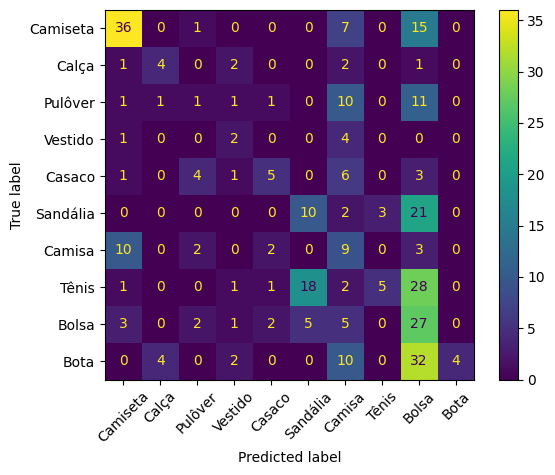

In [25]:
predicoes_otimizado = modelo_otimizado.predict(test_ext_X)

plot_confusion_matrix(test_ext_Y, predicoes_otimizado)

### Conclusão

In [26]:
df_model_metrics

,model,model_accuracy,precision_macro_avg,recall_macro_avg,f1_score_macro_avg,support_macro_avg,precision_weighted_avg,recall_weighted_avg,f1_score_weighted_avg,support_weighted_avg,train_duration,predict_duration
3,SVM-HOG,0.7103,0.704066,0.7103,0.702895,10000,0.704066,0.7103,0.702895,10000,12.493039,1.645960
4,SVM-HOG-OPT,0.8189,0.816812,0.8189,0.817520,10000,0.816812,0.8189,0.817520,10000,136.232328,12.352947
5,SVM,0.7103,0.704066,0.7103,0.702895,10000,0.704066,0.7103,0.702895,10000,12.471400,1.600001
